## Analysis of Fracture Form in MrOS V1 Data (EDA3-V1-FF.ipynb)
The Fracture Form is essential in understanding the occurrence, characteristics, and management of fractures within the study population. It provides valuable insights into the prevalence of fractures, associated risk factors, treatment patterns, and the impact of fractures on the participants' health and well-being.

#### 1. [Installation and Importing of Libraries](#eda_import)
#### 2. [Retreival of Data](#eda_retrieval)
#### 3. [Fracture Form Analysis](#eda_form)
#### 4. [Results for Modeling](#eda_FR)


### <a name="eda_import"></a>Installation and Importing of Libraries
In order to both explore and visualize the data, it's necessary for us to load various libraries.  In addition to loading already pre-installed libraries, we've also had to install seaborn for plotting. 

In [1]:
!pip install seaborn --upgrade

Requirement already up-to-date: seaborn in /opt/conda/lib/python3.7/site-packages (0.12.2)


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
from sklearn.decomposition import PCA
import mpl_toolkits.mplot3d
from scipy.stats import chi2_contingency


### <a name="eda_retrieval"></a>Retreival of Data
The data needs to be retrieved from the Postgres database and stored in a dataframe for us to begin analyzing.

In [3]:
import psycopg2
import sqlalchemy
import getpass

user = "jwj8c8"
host = "pgsql.dsa.lan"
database = "casestdysu23t03"
password = getpass.getpass()
connectionstring = "postgresql://" + user + ":" + password + "@" + host + "/" + database
engine = sqlalchemy.create_engine(connectionstring)
connection = None

try:
    connection = engine.connect()
except Exception as err:
    print("An error has occurred trying to connect: {}".format(err))

del password

········


In [4]:
def binary2StringLiteral(df):
    for column in df.columns:
        if df[column].dtype == "object":
            df[column] = df[column].str.decode('utf-8')

In [5]:
def chi2Results(res,alpha=0.05):
    print(f"The p-value is: {res[1]}")
    print(f"The test statistic is: {res[0]}")
    if res[1] > alpha:
        print("Thus we cannot reject the null hypthesis and the two variables are independent")
    else:
        print("Thus we must reject the null hypothesis and conclude the two variables are not independent")

In [6]:
fafeb23_df = pd.read_sas("/dsa/groups/casestudy2023su/team03/FAFEB23.SAS7BDAT")
fafeb23_df = fafeb23_df[["ID","FANOTMOF"]]
binary2StringLiteral(fafeb23_df)

<h2><a name="eda_form"></a> Fracture Form Analysis </h2>

<h3> Family History </h3>

In [7]:
query = "SELECT * FROM public.v1_form_FF"
form_ff_df = pd.read_sql_query(query, con=connection)

##Remove Staff IDs
##form_ff_df = form_ff_df.drop(form_ff_df.filter(regex="(STAFF)",axis=1).columns,axis=1)

In [8]:
form_ff_df = form_ff_df.loc[:,form_ff_df.columns.str.startswith(("FF","ID"))]

In [9]:
FFFX50_cats = {0:"0: NO FRACTURE BEFORE BASELINE",1:"1: FRACTURE AFTER AGE 50, BEFORE BASELINE",\
              2:"2: FRACTURE BEFORE AGE 50"}
form_ff_df.FFFX50 = form_ff_df.FFFX50.map(FFFX50_cats)

In [10]:
family_fractures = form_ff_df.filter(regex="(MOM)|(DAD)|(DAUGH)|(SON)|(SIS)|(BRO)")

In [11]:
family_fractures.isna().sum().T

FFMOMOST    2299
FFMOMFX     1762
FFMOMHIP    4703
FFMOMWST    4802
FFMOMSPN    4755
FFMOMOTH    4931
FFMOM         36
FFMOMAGE    5659
FFMOMDIE     393
FFDADOST    2202
FFDADFX     2647
FFDADHIP    5140
FFDADWST    5198
FFDADSPN    5146
FFDADOTH    5202
FFDAD         91
FFDAUGH        0
FFDADAGE    5928
FFDADDIE     201
FFSIS          5
FFBRO          3
FFSON          2
dtype: int64

The variables of interest in the family history portion of FF form have such a large amount of missing values (>50% in most cases) that it would be innapropriate to use.

<h3> Fracture History </h3>

In [12]:
##Only keep data related to the subject
fracture_hist = form_ff_df.drop(family_fractures.columns,axis=1)

In [13]:
pd.set_option('display.max_rows', None)
print(fracture_hist.isna().sum().T)
pd.reset_option('display.max_rows')

ID             0
FFFRAC         1
FFHIP       2677
FFHIPAG1    5895
FFHIPTR1    5903
FFHIPAG2    5992
FFHIPTR2    5992
FFHIPAG3    5994
FFHIPTR3    5994
FFWST       2677
FFWSTAG1    4978
FFWSTTR1    5076
FFWSTAG2    5832
FFWSTTR2    5849
FFWSTAG3    5968
FFWSTTR3    5971
FFSPN       2677
FFSPNAG1    5760
FFSPNTR1    5826
FFSPNAG2    5976
FFSPNTR2    5982
FFSPNAG3    5993
FFSPNTR3    5993
FFSLD       2677
FFSLDAG1    5550
FFSLDTR1    5600
FFSLDAG2    5970
FFSLDTR2    5974
FFSLDAG3    5993
FFSLDTR3    5993
FFUAM       2677
FFUAMAG1    5851
FFUAMTR1    5873
FFUAMAG2    5987
FFUAMTR2    5987
FFUAMAG3    5994
FFUAMTR3    5994
FFRCS       2677
FFRCSAG1    5113
FFRCSTR1    5293
FFRCSAG2    5848
FFRCSTR2    5883
FFRCSAG3    5958
FFRCSTR3    5963
FFULG       2677
FFULGAG1    5915
FFULGTR1    5932
FFULGAG2    5991
FFULGTR2    5992
FFULGAG3    5993
FFULGTR3    5994
FFKNC       2677
FFKNCAG1    5841
FFKNCTR1    5862
FFKNCAG2    5986
FFKNCTR2    5989
FFKNCAG3    5994
FFKNCTR3    5994
FFLLG       26

Many of the features have a large chunk of missing data. This is in part due to hierarchal survey questions and we could replace with zeroes. But at this stage we will drop data that is not hight fidelity.

In [14]:
##Keep only high fidelity data
fracture_hist = fracture_hist.dropna(axis=1,thresh=5800)

In [15]:
fracture_hist.columns

Index(['ID', 'FFFRAC', 'FFNOHP', 'FFNOSP', 'FFNOHS', 'FFNOHSW', 'FFNT504',
       'FFNT502', 'FFNTGT50', 'FFNTLE50', 'FFNMGT50', 'FFNMLE50', 'FFFX50',
       'FF'],
      dtype='object')

In [16]:
fracture_hist = fracture_hist.merge(fafeb23_df,on="ID")

In [17]:
fracture_hist.shape
ff_with_nulls = fracture_hist

In [18]:
fracture_hist.FFFRAC = fracture_hist.FFFRAC.astype(str)

For the purposes of this analysis we want to determine if having previous history of fracture in general is indicative of future fractures.

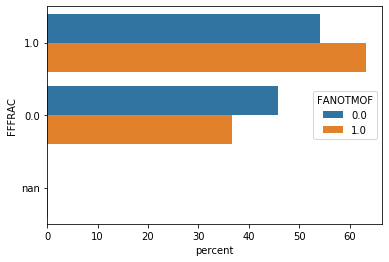

In [19]:
plot_data = fracture_hist.groupby("FANOTMOF")["FFFRAC"].value_counts(normalize=True).mul(100).rename("percent").reset_index()
sns.barplot(data=plot_data,x="percent",y="FFFRAC", hue="FANOTMOF")

In [20]:
pd.crosstab(fracture_hist.FFFRAC,fracture_hist.FANOTMOF)

FANOTMOF,0.0,1.0
FFFRAC,,
0.0,2407,244
1.0,2842,421
nan,0,1


In [21]:
pd.crosstab(fracture_hist.FFFRAC,fracture_hist.FANOTMOF,normalize="index")

FANOTMOF,0.0,1.0
FFFRAC,,
0.0,0.907959,0.092041
1.0,0.870978,0.129022
nan,0.000000,1.000000


In [22]:
contingency = pd.crosstab(fracture_hist.FFFRAC,fracture_hist.FANOTMOF)
res = chi2_contingency(contingency)

In [23]:
pd.DataFrame(res[3])

,0,1
0,2352.510397,298.489603
1,2895.602198,367.397802
2,0.887405,0.112595


In [24]:
chi2Results(res)

The p-value is: 8.727298778204382e-07
The test statistic is: 27.903279494581447
Thus we must reject the null hypothesis and conclude the two variables are not independent


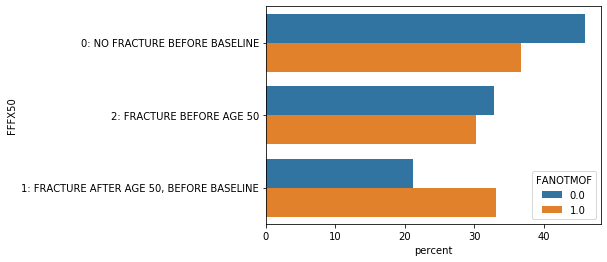

In [25]:
plot_data = fracture_hist.groupby("FANOTMOF")["FFFX50"].value_counts(normalize=True).mul(100).rename("percent").reset_index()
sns.barplot(data=plot_data,x="percent",y="FFFX50", hue="FANOTMOF")

In [26]:
pd.crosstab(fracture_hist.FANOTMOF,fracture_hist.FFFX50)

FFFX50,0: NO FRACTURE BEFORE BASELINE,"1: FRACTURE AFTER AGE 50, BEFORE BASELINE",2: FRACTURE BEFORE AGE 50
FANOTMOF,,,
0.0,2407,1109,1725
1.0,244,220,201


In [27]:
pd.crosstab(fracture_hist.FANOTMOF,fracture_hist.FFFX50,normalize="index")

FFFX50,0: NO FRACTURE BEFORE BASELINE,"1: FRACTURE AFTER AGE 50, BEFORE BASELINE",2: FRACTURE BEFORE AGE 50
FANOTMOF,,,
0.0,0.459263,0.211601,0.329136
1.0,0.366917,0.330827,0.302256


In [28]:
contingency = pd.crosstab(fracture_hist.FANOTMOF,fracture_hist.FFFX50)
res = chi2_contingency(contingency)

In [29]:
pd.DataFrame(res[3])

,0,1,2
0,2352.504402,1179.35811,1709.137487
1,298.495598,149.64189,216.862513


In [30]:
chi2Results(res)

The p-value is: 1.53703591538416e-11
The test statistic is: 49.79716038290502
Thus we must reject the null hypothesis and conclude the two variables are not independent


### <a name="eda_FR"></a>Results for Modeling

From this form, the variable that provides the most information is FFFX50, so to remove noise and capture the most variance that is what we will import into the final model.

In [31]:
results = form_ff_df[["ID","FFFX50"]]

In [33]:
results.to_csv("/dsa/groups/casestudy2023su/team03/model_data/ff_results.csv",index=False)
os.chmod("/dsa/groups/casestudy2023su/team03/model_data/ff_results.csv",0o777)

file_path_with_nulls = "/dsa/groups/casestudy2023su/team03/model_data/null_included/FF_results_with_nulls.csv"
ff_with_nulls.to_csv(file_path_with_nulls, index=False)
os.chmod(file_path_with_nulls, 0o777)